In [17]:

# This code does delta-pdf (punch and fill) on the irinse dataset
# utilities

import numpy as np
import math
import time
import scipy.signal
from   astropy.convolution import convolve, Kernel
from   nexusformat.nexus import *
import os
import matplotlib.pyplot as plt
from math import gamma
from scipy.special import kn

def _round_up_to_odd_integer(value):
    i = int(math.ceil(value))
    if i % 2 == 0:
        return i + 1
    else:
        return i

class Gaussian3DKernel(Kernel):
    #
    _separable = True
    _is_bool   = False
    #
    def __init__(self, stddev, **kwargs):
        x                  = np.linspace(-15., 15., 17)
        y                  = np.linspace(-15., 15., 17)
        z                  = np.linspace(-15., 15., 17)
        X,Y,Z              = np.meshgrid(x,y,z)
        array              = np.exp(-(X**2+Y**2+Z**2)/(2*stddev**2))
        self._default_size = _round_up_to_odd_integer(8 * stddev)
        super(Gaussian3DKernel, self).__init__(array)
        self.normalize()
        self._truncation   = np.abs(1. - self._array.sum())

gkernal = Gaussian3DKernel(2)

class Matern3DKernel(Kernel):
    #
    _separable = True
    _is_bool   = False
    #
    def __init__(self, sig2, nu, rho, **kwargs):
        x                  = np.linspace(-15., 15., 17)
        y                  = np.linspace(-15., 15., 17)
        z                  = np.linspace(-15., 15., 17)
        X,Y,Z              = np.meshgrid(x,y,z)
        d                  = np.sqrt(X**2+Y**2+Z**2)
        # array              = np.exp(-(X**2+Y**2+Z**2)/(2*stddev**2))
        array              = sig2*(2**(1-nu)/gamma(nu))*(np.sqrt(2*nu)*d/rho)**nu*(kn(nu,np.sqrt(2*nu)*d/rho))
        self._default_size = _round_up_to_odd_integer(8 * sig2)
        super(Matern3DKernel, self).__init__(array)
        self.normalize()
        self._truncation   = np.abs(1. - self._array.sum())

mkernel = Matern3DKernel(1.0,0.5,1.0)

def flipaxis(A,i):
    Aprime = np.swapaxes(np.swapaxes(A,0,i)[::-1],0,i)
    return Aprime

/Users/charlottehaley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: floating point number truncated to an integer
/Users/charlottehaley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in multiply


In [2]:
# Specific to this dataset we have a domain size of 16 reciprocal space units (whitespace trimmed)

Qh_lim = 16
Qk_lim = 16
Ql_lim = 16

# resolution of 0.05 therefore 20 data points for each unit. 
# implied limits for what punch and fill will do
kmin = 20*(16-Ql_lim)
kmax = 20*(16+Ql_lim)
jmin = 20*(16-Qk_lim)
jmax = 20*(16+Qk_lim)
imin = 20*(16-Qh_lim)
imax = 20*(16+Qh_lim)

ksteps = kmax-kmin+1
jsteps = jmax-jmin+1
isteps = imax-imin+1

xvals  = np.linspace(-10,10-20./isteps,isteps)
yvals  = np.linspace(-10,10-20./jsteps,jsteps)
zvals  = np.linspace(-10,10-20./ksteps,ksteps)

xfield = NXfield(xvals,name='x')
yfield = NXfield(yvals,name='y')
zfield = NXfield(zvals,name='z')

# load in the data, where I have it stored locally

#temp = '100K'
from pathlib import Path
home = str(Path.home())
irinse_100K = nxload(home+'/Documents/Data/Xray/irinse_100K.nxs')
irinse_100K.unlock()


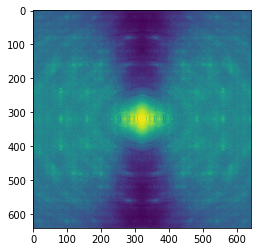

In [3]:
# imshow because matplotlib is slow
plt.imshow(irinse_100K.entry.symm_transform[-16.:16.,-16.:16.,1.5].data)

In [5]:
# Generate the space where we'll put the punch and fill in the nexpy tree, based on the indices and
# the choices we've made. 
# large limits for punch and fill small limits for FT

punch_irinse                   = NXroot()
punch_irinse['entry']          = NXentry()
punch_irinse['entry']['data']  = NXdata(NXfield(np.zeros((641,641,641)),name='data'),[irinse_100K.entry.symm_transform[-16.:16.,-16.:16.,-16.:16.].Ql,irinse_100K.entry.symm_transform[-16.:16.,-16.:16.,-16.:16.].Qk,irinse_100K.entry.symm_transform[-16.:16.,-16.:16.,-16.:16.].Qh])
interp_irinse = punch_irinse

## Define the axes over which we define what gets punched, and what doesn't 
L,K,H = np.meshgrid(irinse_100K.entry.symm_transform[-16.:16.,-16.:16.,-16.:16.].Ql.nxdata,irinse_100K.entry.symm_transform[-16.:16.,-16.:16.,-16.:16.].Qk.nxdata,irinse_100K.entry.symm_transform[-16.:16.,-16.:16.,-16.:16.].Qh.nxdata,indexing='ij')
#
## Define the punch points anywhere in the ellipsoid gets replaced with a nan
## only integer points have been naned here, can do half-integers as well
# 0.2001 was original radius
punch_locs = np.where(((L-np.rint(L))**2/(1.**2)+(K-np.rint(K))**2/(1.**2)+(H-np.rint(H))**2/(1.**2))<(0.1001)**2,np.nan*np.ones((641,641,641)),np.ones((641,641,641)))

punch_locs[np.isnan(punch_locs) == 0]=1;


In [ ]:
#plt.imshow(punch_locs[1:100,1:100,300])

In [6]:
# 641 pixel cube area takes half an hour, done only on one octant
# I substitute here the fast julia convolution to speed things up 

from julia import Julia
julia = Julia(compiled_modules=False)
from julia import FastConv


In [7]:
# Fourier transform part
g                              = nxload('/users/charlottehaley/Documents/Data/Xray/irinse_100K.nxs') 
g.unlock()
fft_irinse_100K                = NXroot()
fft_irinse_100K['entry']       = NXentry()
    
# Perform the punch
punch_irinse.entry.data.data   = np.multiply(g.entry.symm_transform[-16.:16.,-16.:16.,-16.:16.].data, punch_locs)

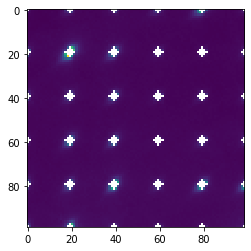

In [8]:
#plt.imshow(g.entry.symm_transform[-16.:16.,-16.:16.,-16.:16.].data[1:100,1:100,300]) 
plt.imshow(g.entry.symm_transform[-16.:16.,-16.:16.,-16.:16.].data[1:100,1:100,300]*punch_locs[1:100,1:100,300])

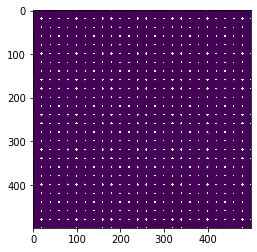

In [9]:
plt.imshow(punch_irinse.entry.data.data[1:500,1:500,300].nxdata) 
# punch_irinse.entry.data.data[:,:,300]

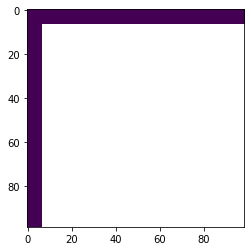

In [20]:
#start                          = time.time()
# Do the interpolation
vvals                          = np.zeros((641,641,641))
# Convolution happens over a single octant of the dataset
vvals[300:641,300:641,300:641] = convolve(punch_irinse.entry.data[-1.:16.,-1.:16.,-1.:16.].data.nxdata,gkernal)
# vvals[300:641,300:641,300:641] = FastConv.convn(punch_irinse.entry.data[-1.:16.,-1.:16.,-1.:16.].data.nxdata,gkernal.array)[8:349,8:349,8:349]

vvals[320:641,320:641,0:321]   = flipaxis(vvals[320:641,320:641,320:641],2)
vvals[320:641,0:321,0:641]     = flipaxis(vvals[320:641,320:641,0:641],1)
vvals[0:321,0:641,0:641]       = flipaxis(vvals[320:641,0:641,0:641],0)
interp_irinse.entry.data.data  = vvals
    
#print ('Interpolation time for fft: ' + str(end-start))
plt.imshow(vvals[1:100,1:100,300])

/Users/charlottehaley/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/Users/charlottehaley/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/Users/charlottehaley/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/Users/charlottehaley/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/Users/charlottehaley/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:885: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/Users/charlottehaley/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:713: UserWarning: Warning: converting a masked

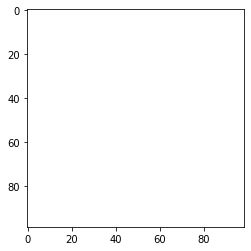

In [19]:
vvals                          = np.zeros((641,641,641))
# Convolution happens over a single octant of the dataset
vvals[300:641,300:641,300:641] = convolve(punch_irinse.entry.data[-1.:16.,-1.:16.,-1.:16.].data.nxdata,mkernel)
# vvals[300:641,300:641,300:641] = FastConv.convn(punch_irinse.entry.data[-1.:16.,-1.:16.,-1.:16.].data.nxdata,gkernal.array)[8:349,8:349,8:349]

vvals[320:641,320:641,0:321]   = flipaxis(vvals[320:641,320:641,320:641],2)
vvals[320:641,0:321,0:641]     = flipaxis(vvals[320:641,320:641,0:641],1)
vvals[0:321,0:641,0:641]       = flipaxis(vvals[320:641,0:641,0:641],0)
interp_irinse.entry.data.data  = vvals

plt.imshow(vvals[1:100,1:100,300])

In [ ]:
    
# symmetrized again
# take the convolved array and turn the naned locs and turn them into ones
nan_locs                       = np.where(np.isnan(punch_irinse.entry.data.data.nxdata)==1,np.ones((641,641,641)),np.zeros((641,641,641)))
non_nan_locs                   = -1*nan_locs+1
    
# use the symmetrized array where we didn't do the punch, this can cause problems in the
# convolved areas and then the non convolved areas.
interp_irinse.entry.data.data  = g.entry.symm_transform[-16.:16.,-16.:16.,-16.:16.].data.nxdata*non_nan_locs+interp_irinse.entry.data.data[:,:,:].nxdata*nan_locs
end                            = time.time()

In [10]:

fin                            = interp_irinse
# DO a background substraction - what is the minimum spherically symmetric background - not
# rigorously based on anything
#vvals                          = fin.entry.data[kmin:kmax,jmin:jmax,imin:imax].data.nxdata-irinse_background.entry.symm_transform[-16.:15.95,-16.:15.95,-16.:15.95].data.nxdata-7.

# Anything less than zero is set to zero. No intensity should be less than zero
vvals[vvals < 0]               = 0
fourier                        = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(vvals)))
fourier_field                  = NXfield(np.real(fourier),name='fft')
fft_irinse_100K.entry.data     = NXdata(fourier_field,[zfield,yfield,xfield])
# nxsave('/data3/GUP-59139/irinse/xtal1/'+str(temp)+'K/'+fout_name+'.nxs',nxtree[fout_name])
    
if os.path.isfile('/users/charlottehaley/Documents/Data/Xray/fft_irinse_100K.nxs'):
    os.remove('/users/charlottehaley/Documents/Data/Xray/fft_irinse_100K.nxs')
fft_irinse_100K.save('/users/charlottehaley/Documents/Data/Xray/fft_irinse_100K.nxs')
#if 'ceps' not in g['entry']:
#    g['entry']['ceps']          = NXdata(NXlink(target='entry/data/fft',file=directory_name+fout_name+'.nxs',name='data'),[zfield,yfield,xfield])
g.lock()
print ('fft finished!')

/Users/charlottehaley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


fft finished!


In [16]:
interp_irinse.entry.data.data

NXfield(array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, 